In [42]:
import os.path as osp


def load_annotation(root, image_key):
    with open(os.path.join(root, 'annotations', '{:s}.json'.format(image_key)), 'r') as fid:
        anno = json.load(fid)
    return anno

def convert_mapillary_to_coco(root, keys_file, class_map_file, outfile):
    with open(os.path.join(root, class_map_file), 'r') as fid:
        class_to_id = json.load(fid)
    split = keys_file.split('.')[0]
    
    annotations = []
    images = []
    obj_count = 0
    
    with open(os.path.join(root, keys_file), 'r') as file:
        keys = file.readlines()
        keys = [key.rstrip() for key in keys]

        for idx, key in enumerate(keys):
            ann = load_annotation(root, key)
            if ann['ispano']:
                continue
            images.append(dict(
                        id=idx,
                        file_name='{:s}.jpg'.format(key),
                        height=ann['height'],
                        width=ann['width']))
            
            for obj in ann['objects']:
                label = obj['label']
                bbox = obj['bbox']
                x_min, y_min, x_max , y_max = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
                data_anno = dict(
                    image_id=idx,
                    id=obj_count,
                    category_id=class_to_id[label],
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    segmentation = [[x_min, y_min, x_min, y_max, x_max, y_max, x_max, y_min]],
                    area=(x_max - x_min) * (y_max - y_min),
                    iscrowd=0)
                annotations.append(data_anno)
                obj_count+=1
    categories = []
    for key in class_to_id.keys():
        categories.append(dict(id=class_to_id[key],
                         name = key))
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories)
    assert outfile != None
    with open(os.path.join(root, outfile), 'w') as fp:
        json.dump(coco_format_json, fp)
                

In [14]:
import json
import os
from collections import defaultdict

#specific_classes = []

def generate_class_to_id(root_dir, save = False, out_file = None):
    files = os.listdir(os.path.join(root_dir,'annotations'))
    classes = []
    class_to_id = dict()
    for file in files:
        with open(os.path.join(root_dir,'annotations', file)) as fid:
            anno = json.load(fid)
            for obj in anno['objects']:
                label = obj['label']
                if label not in classes:
                    classes.append(label)
    for idx, clas in enumerate(classes):
        class_to_id[clas] = idx
    if save == True:
        assert out_file != None
        with open(os.path.join(root_dir, out_file), 'w') as fp:
            json.dump(class_to_id, fp)
    return class_to_id

In [40]:
class_to_id2 = generate_class_to_id('mapillary_sample', save = True, out_file = 'temp_class_map.json')

In [43]:
convert_mapillary_to_coco('mapillary_sample', 'train.txt', 'temp_class_map.json', 'temp_coco_train.json')

Visualize
https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [44]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [45]:
dataDir='mapillary_sample'
dataType='train'
annFile='{}/temp_coco_train.json'.format(dataDir,dataType)

In [47]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [70]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
other-sign regulatory--keep-right--g1 regulatory--priority-over-oncoming-vehicles--g1 regulatory--height-limit--g1 regulatory--maximum-speed-limit-35--g2



In [67]:
catIds = coco.getCatIds(catNms=['other-sign']);
imgIds = coco.getImgIds(catIds=catIds );
#imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

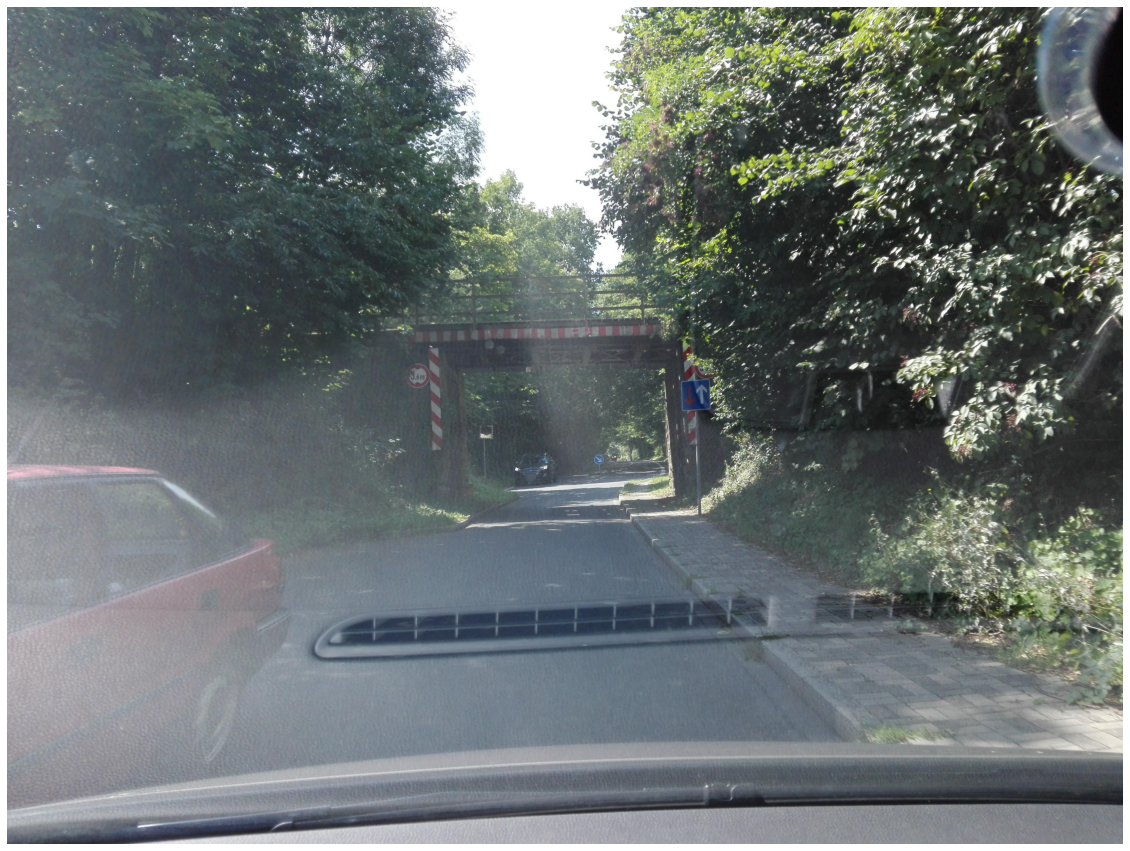

In [68]:
I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

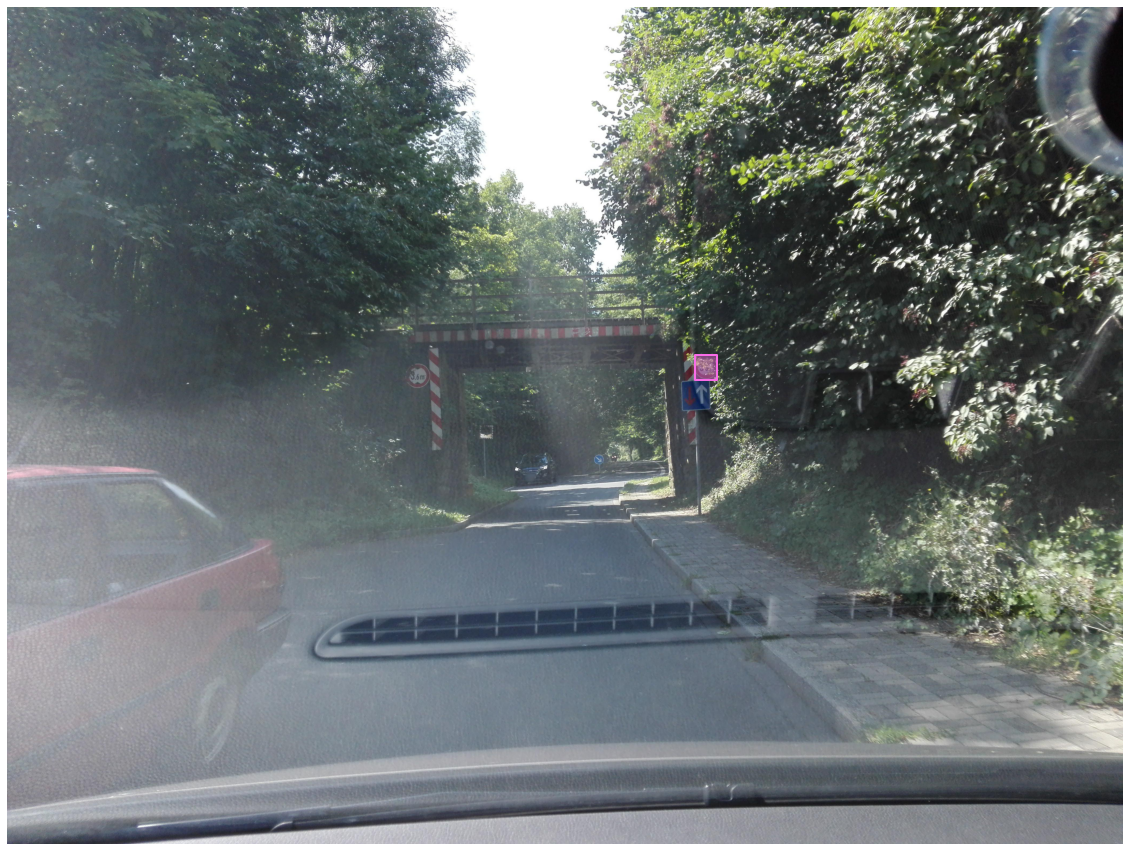

In [69]:
pylab.rcParams['figure.figsize'] = (20,20)
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)